In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shayanfazeli/heartbeat")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'heartbeat' dataset.
Path to dataset files: /kaggle/input/heartbeat


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
dataset_path = "/kaggle/input/heartbeat"

print("Files in dataset directory:")
for file in os.listdir(dataset_path):
    if file.endswith('.csv'):
        file_path = os.path.join(dataset_path, file)
        file_size = os.path.getsize(file_path) / (1024 * 1024)  # Size in MB
        print(f"  - {file} ({file_size:.2f} MB)")

Files in dataset directory:
  - ptbdb_abnormal.csv (47.09 MB)
  - ptbdb_normal.csv (18.14 MB)
  - mitbih_test.csv (98.13 MB)
  - mitbih_train.csv (392.44 MB)


In [4]:
mitbih_train = pd.read_csv(os.path.join(dataset_path, 'mitbih_train.csv'), header=None)
mitbih_test = pd.read_csv(os.path.join(dataset_path, 'mitbih_test.csv'), header=None)


print("Dataset shapes:")
print(f"MIT-BIH Train: {mitbih_train.shape}")
print(f"MIT-BIH Test: {mitbih_test.shape}")


Dataset shapes:
MIT-BIH Train: (87554, 188)
MIT-BIH Test: (21892, 188)


EXPLORE MIT-BIH TRAIN DATASET

In [5]:
print("MIT-BIH Train Dataset Info:")
print(f"Shape: {mitbih_train.shape}")
print(f"Number of features (ECG signal points): {mitbih_train.shape[1] - 1}")
print(f"Number of samples: {mitbih_train.shape[0]}")
print(f"\nFirst 5 rows:")
print(mitbih_train.head())
print(f"\Labels column value counts:")
print(mitbih_train.iloc[:, -1].value_counts().sort_index())
print(f"\nData types:")
print(mitbih_train.dtypes.value_counts())
print(f"\nMissing values:")
print(mitbih_train.isnull().sum().sum())

MIT-BIH Train Dataset Info:
Shape: (87554, 188)
Number of features (ECG signal points): 187
Number of samples: 87554

First 5 rows:
        0         1         2         3         4         5         6    \
0  0.977941  0.926471  0.681373  0.245098  0.154412  0.191176  0.151961   
1  0.960114  0.863248  0.461538  0.196581  0.094017  0.125356  0.099715   
2  1.000000  0.659459  0.186486  0.070270  0.070270  0.059459  0.056757   
3  0.925414  0.665746  0.541436  0.276243  0.196133  0.077348  0.071823   
4  0.967136  1.000000  0.830986  0.586854  0.356808  0.248826  0.145540   

        7         8         9    ...  178  179  180  181  182  183  184  185  \
0  0.085784  0.058824  0.049020  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.088319  0.074074  0.082621  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.043243  0.054054  0.045946  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.060773  0.066298  0.058011  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.089202  0.11

<>:7: SyntaxWarning: invalid escape sequence '\L'
<>:7: SyntaxWarning: invalid escape sequence '\L'
/tmp/ipython-input-2271700524.py:7: SyntaxWarning: invalid escape sequence '\L'
  print(f"\Labels column value counts:")


EXTRACT FEATURES AND LABELS

In [6]:
X_train = mitbih_train.iloc[:, :-1].values
y_train = mitbih_train.iloc[:, -1].values

print("MIT-BIH Train Statistics:")
print(f"Features shape: {X_train.shape}")
print(f"Labels shape: {y_train.shape}")
print(f"\nLabel distribution:")
unique_labels, counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"  Class {int(label)}: {count} samples ({count/len(y_train)*100:.2f}%)")

print(f"\nFeature statistics:")
print(f"  Min value: {X_train.min():.6f}")
print(f"  Max value: {X_train.max():.6f}")
print(f"  Mean value: {X_train.mean():.6f}")
print(f"  Std deviation: {X_train.std():.6f}")

MIT-BIH Train Statistics:
Features shape: (87554, 187)
Labels shape: (87554,)

Label distribution:
  Class 0: 72471 samples (82.77%)
  Class 1: 2223 samples (2.54%)
  Class 2: 5788 samples (6.61%)
  Class 3: 641 samples (0.73%)
  Class 4: 6431 samples (7.35%)

Feature statistics:
  Min value: 0.000000
  Max value: 1.000000
  Mean value: 0.174283
  Std deviation: 0.226327


VISUALIZE SAMPLE ECG SIGNALS FROM DIFERENT CLASSES

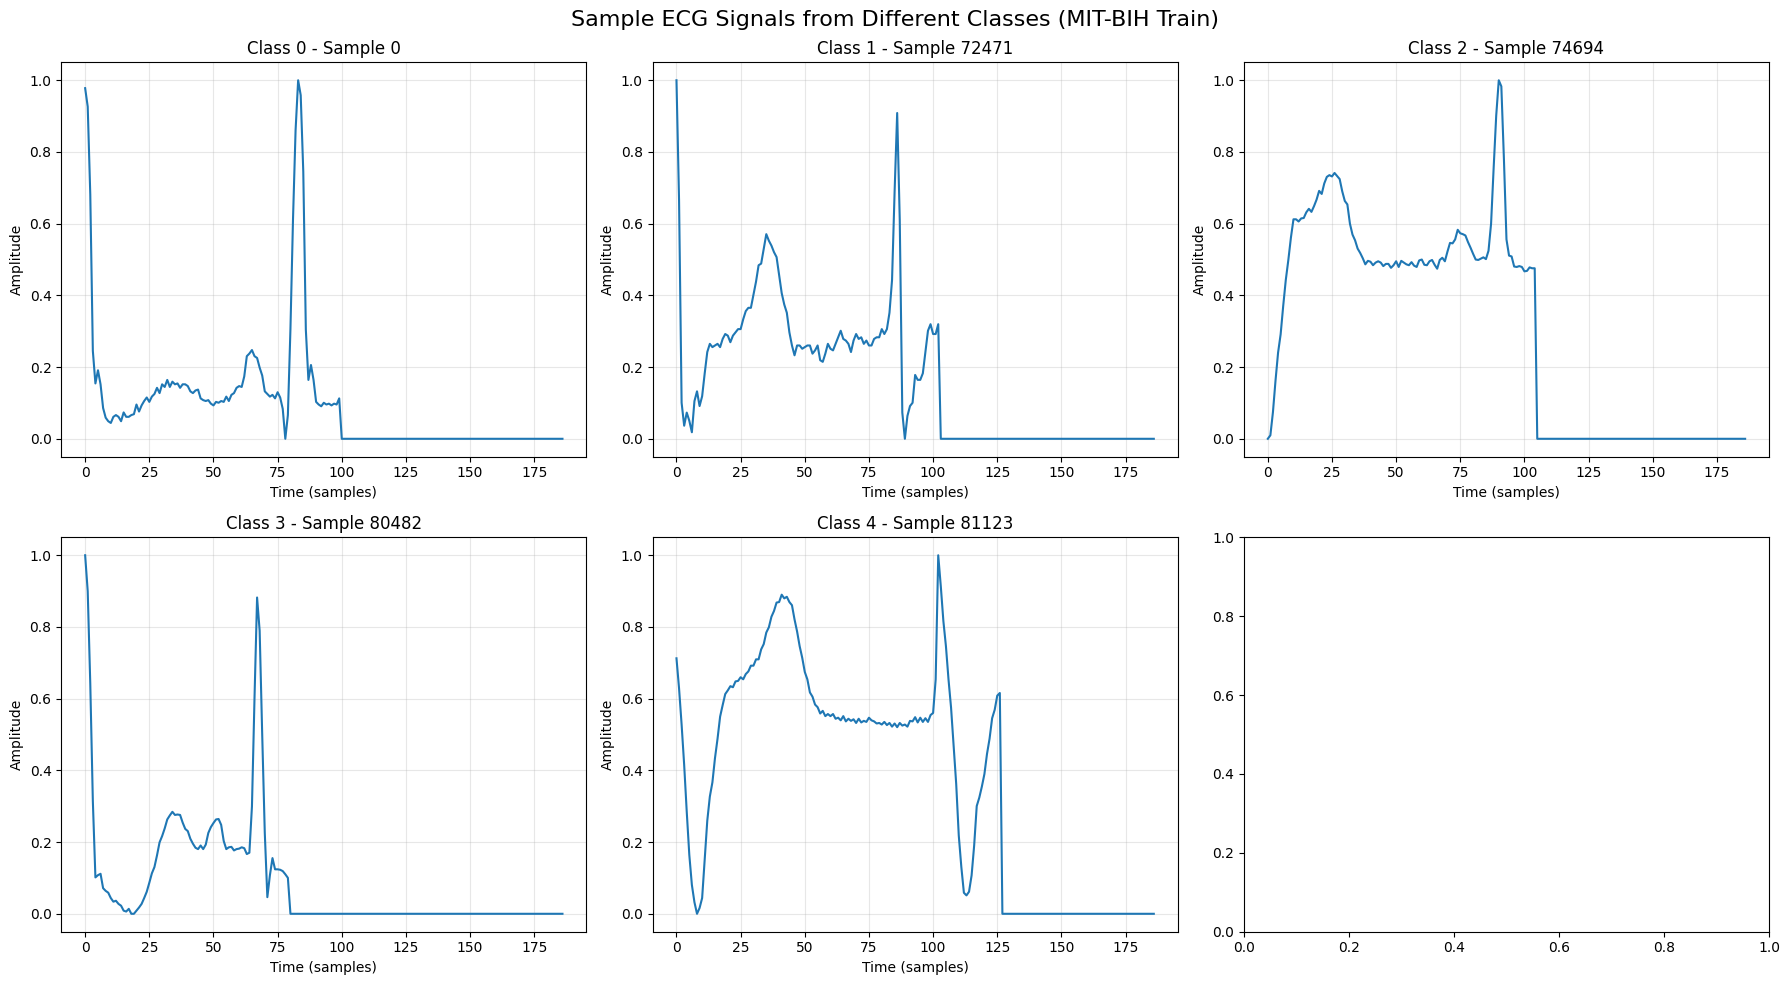

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Sample ECG Signals from Different Classes (MIT-BIH Train)', fontsize=16)

unique_labels = np.unique(y_train)
for idx, label in enumerate(unique_labels[:5]):
    row = idx // 3
    col = idx % 3

    sample_idx = np.where(y_train == label)[0][0]
    signal = X_train[sample_idx]

    axes[row, col].plot(signal)
    axes[row, col].set_title(f'Class {int(label)} - Sample {sample_idx}')
    axes[row, col].set_xlabel('Time (samples)')
    axes[row, col].set_ylabel('Amplitude')
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

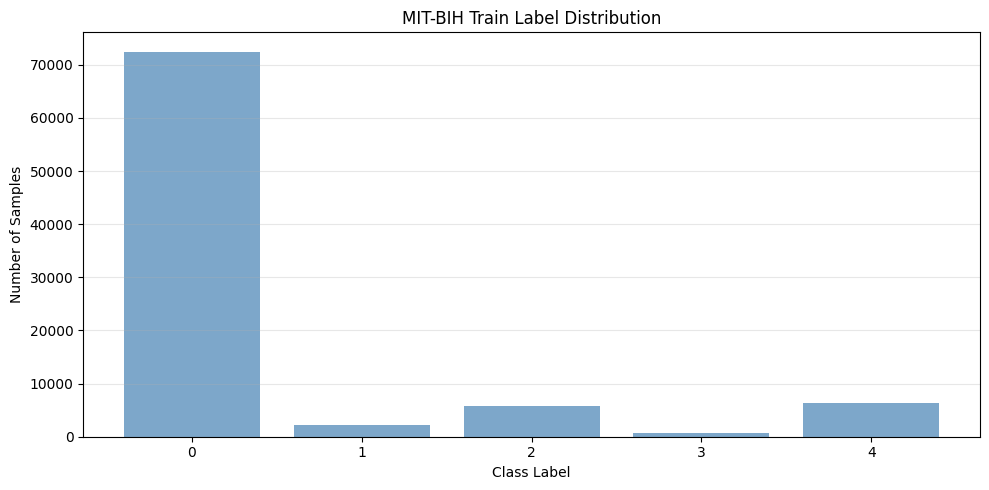

In [23]:
# Label distribution only
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

unique_labels, counts = np.unique(y_train, return_counts=True)
ax.bar(unique_labels, counts, color='steelblue', alpha=0.7)
ax.set_xlabel('Class Label')
ax.set_ylabel('Number of Samples')
ax.set_title('MIT-BIH Train Label Distribution')
ax.grid(True, alpha=0.3, axis='y')
plt.savefig("labeldistribtion.pdf", format="pdf", bbox_inches="tight")
plt.tight_layout()

plt.show()

In [14]:
X_train = mitbih_train.iloc[:, :-1].values
y_train = mitbih_train.iloc[:, -1].values
X_test  = mitbih_test.iloc[:, :-1].values
y_test  = mitbih_test.iloc[:, -1].values

X_train = X_train[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)
num_classes = len(np.unique(y_train_enc))

y_train_oh = keras.utils.to_categorical(y_train_enc, num_classes)
y_test_oh  = keras.utils.to_categorical(y_test_enc, num_classes)

# Class weights to handle imbalance
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_enc),
    y=y_train_enc
)
class_weight_dict = dict(enumerate(class_weights))

print("Class weights:", class_weight_dict)

# Split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train_oh, test_size=0.2, random_state=42, stratify=y_train_enc
)


Class weights: {0: np.float64(0.24162492583240192), 1: np.float64(7.877103013945119), 2: np.float64(3.0253628196268143), 3: np.float64(27.317940717628705), 4: np.float64(2.7228735810915876)}


In [11]:
def residual_block(x, filters, kernel_size=3):
    shortcut = x

    x = layers.Conv1D(filters, kernel_size, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv1D(filters, kernel_size, padding="same")(x)
    x = layers.BatchNormalization()(x)

    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv1D(filters, 1, padding="same")(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.Activation("relu")(x)
    return x

def create_resnet_1d(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv1D(64, 7, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling1D(3)(x)

    x = residual_block(x, 64)
    x = layers.MaxPooling1D(2)(x)
    x = residual_block(x, 128)
    x = layers.MaxPooling1D(2)(x)
    x = residual_block(x, 256)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

input_shape = (X_train.shape[1], X_train.shape[2])   # (187, 1)
model = create_resnet_1d(input_shape, num_classes)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 187, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 187, 64)   │        512 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 187, 64)   │        256 │ conv1d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 187, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 62, 64)    │          0 │ activation_7[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 62, 64)    │     12,352 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 62, 64)    │        256 │ conv1d_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 62, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 62, 64)    │     12,352 │ activation_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 62, 64)    │        256 │ conv1d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 62, 64)    │          0 │ batch_normalizat… │
│                     │                   │            │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 62, 64)    │          0 │ add_3[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 31, 64)    │          0 │ activation_9[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 31, 128)   │     24,704 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 128)   │        512 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 31, 128)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 31, 128)   │     49,280 │ activation_10[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 31, 128)   │      8,320 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 128)   │        512 │ conv1d_13[0][0] 

 Total params: 474,885 (1.81 MB)

 Trainable params: 472,197 (1.80 MB)

 Non-trainable params: 2,688 (10.50 KB)

Train Model

In [12]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10,
                                  restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                                      patience=5, min_lr=1e-7, verbose=1),
    keras.callbacks.ModelCheckpoint("best_resnet1d_mitbih.h5",
                                    monitor="val_accuracy",
                                    save_best_only=True, verbose=1)
]

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6183 - loss: 0.7452
Epoch 1: val_accuracy improved from -inf to 0.92999, saving model to best_resnet1d_mitbih.h5


1095/1095 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - accuracy: 0.6184 - loss: 0.7451 - val_accuracy: 0.9300 - val_loss: 0.2607 - learning_rate: 0.0010
Epoch 2/50
1087/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8212 - loss: 0.4186
Epoch 2: val_accuracy did not improve from 0.92999
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8213 - loss: 0.4185 - val_accuracy: 0.9089 - val_loss: 0.2794 - learning_rate: 0.0010
Epoch 3/50
1089/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8455 - loss: 0.3563
Epoch 3: val_accuracy did not improve from 0.92999
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8455 - loss: 0.3563 - val_accuracy: 0.7040 - val_loss: 0.8238 - learning_rate: 0.0010
Epoch 4/50
1089/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8568 - loss: 0.3290
Epoch 4: val_accuracy did not improve from 0.92999
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8569 - loss: 0.3289 - val_accuracy: 0.8774 - val_loss: 0.3498 - learning_rate: 0.0010
Epoch 5/

1095/1095 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8826 - loss: 0.2385 - val_accuracy: 0.9673 - val_loss: 0.1325 - learning_rate: 0.0010
Epoch 7/50
1094/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9011 - loss: 0.2078
Epoch 7: val_accuracy did not improve from 0.96728
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9011 - loss: 0.2078 - val_accuracy: 0.8025 - val_loss: 0.5850 - learning_rate: 0.0010
Epoch 8/50
1090/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9011 - loss: 0.2057
Epoch 8: val_accuracy did not improve from 0.96728
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9011 - loss: 0.2058 - val_accuracy: 0.9422 - val_loss: 0.1912 - learning_rate: 0.0010
Epoch 9/50
1093/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9131 - loss: 0.1996
Epoch 9: val_accuracy did not improve from 0.96728
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9130 - loss: 0.1996 - val_accuracy: 0.9308 - val_loss: 0.2283 - learning_rate: 0.0010
Epoch 10/

1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9751 - loss: 0.0378 - val_accuracy: 0.9744 - val_loss: 0.0953 - learning_rate: 2.5000e-04
Epoch 21/50
1093/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9767 - loss: 0.0362
Epoch 21: val_accuracy did not improve from 0.97436
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9766 - loss: 0.0362 - val_accuracy: 0.9712 - val_loss: 0.0965 - learning_rate: 2.5000e-04
Epoch 22/50
1094/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9709 - loss: 0.0447
Epoch 22: val_accuracy did not improve from 0.97436
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9709 - loss: 0.0447 - val_accuracy: 0.9736 - val_loss: 0.0929 - learning_rate: 2.5000e-04
Epoch 23/50
1089/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9769 - loss: 0.0349
Epoch 23: val_accuracy improved from 0.97436 to 0.97619, saving model to best_resnet1d_mitbih.h5


1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9769 - loss: 0.0349 - val_accuracy: 0.9762 - val_loss: 0.0833 - learning_rate: 2.5000e-04
Epoch 24/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9789 - loss: 0.0322
Epoch 24: val_accuracy did not improve from 0.97619
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9789 - loss: 0.0322 - val_accuracy: 0.9707 - val_loss: 0.1099 - learning_rate: 2.5000e-04
Epoch 25/50
1087/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9824 - loss: 0.0280
Epoch 25: val_accuracy did not improve from 0.97619
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9824 - loss: 0.0281 - val_accuracy: 0.9740 - val_loss: 0.0969 - learning_rate: 2.5000e-04
Epoch 26/50
1087/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9828 - loss: 0.0273
Epoch 26: val_accuracy did not improve from 0.97619
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9828 - loss: 0.0273 - val_accuracy: 0.9747 - val_loss: 0.0879 - learning_rate: 

1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9802 - loss: 0.0315 - val_accuracy: 0.9781 - val_loss: 0.0839 - learning_rate: 2.5000e-04
Epoch 28/50
1090/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9847 - loss: 0.0254
Epoch 28: val_accuracy improved from 0.97807 to 0.97836, saving model to best_resnet1d_mitbih.h5


1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9847 - loss: 0.0255 - val_accuracy: 0.9784 - val_loss: 0.0809 - learning_rate: 2.5000e-04
Epoch 29/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9847 - loss: 0.0266
Epoch 29: val_accuracy did not improve from 0.97836
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9847 - loss: 0.0266 - val_accuracy: 0.9725 - val_loss: 0.1042 - learning_rate: 2.5000e-04
Epoch 30/50
1094/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9817 - loss: 0.0264
Epoch 30: val_accuracy did not improve from 0.97836
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9817 - loss: 0.0264 - val_accuracy: 0.9728 - val_loss: 0.1027 - learning_rate: 2.5000e-04
Epoch 31/50
1092/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9837 - loss: 0.0252
Epoch 31: val_accuracy improved from 0.97836 to 0.98093, saving model to best_resnet1d_mitbih.h5


1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9837 - loss: 0.0252 - val_accuracy: 0.9809 - val_loss: 0.0826 - learning_rate: 2.5000e-04
Epoch 32/50
1089/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9879 - loss: 0.0186
Epoch 32: val_accuracy did not improve from 0.98093
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9879 - loss: 0.0186 - val_accuracy: 0.9804 - val_loss: 0.0806 - learning_rate: 2.5000e-04
Epoch 33/50
1090/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9859 - loss: 0.0237
Epoch 33: val_accuracy did not improve from 0.98093
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9859 - loss: 0.0237 - val_accuracy: 0.9780 - val_loss: 0.0860 - learning_rate: 2.5000e-04
Epoch 34/50
1094/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9839 - loss: 0.0236
Epoch 34: val_accuracy improved from 0.98093 to 0.98287, saving model to best_resnet1d_mitbih.h5


1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9839 - loss: 0.0236 - val_accuracy: 0.9829 - val_loss: 0.0719 - learning_rate: 2.5000e-04
Epoch 35/50
1088/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9869 - loss: 0.0255
Epoch 35: val_accuracy did not improve from 0.98287
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9869 - loss: 0.0255 - val_accuracy: 0.9714 - val_loss: 0.1100 - learning_rate: 2.5000e-04
Epoch 36/50
1088/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9900 - loss: 0.0170
Epoch 36: val_accuracy did not improve from 0.98287
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9900 - loss: 0.0170 - val_accuracy: 0.9810 - val_loss: 0.0848 - learning_rate: 2.5000e-04
Epoch 37/50
1091/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9879 - loss: 0.0206
Epoch 37: val_accuracy did not improve from 0.98287
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9879 - loss: 0.0207 - val_accuracy: 0.9806 - val_loss: 0.0835 - learning_rate:

1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9866 - loss: 0.0212 - val_accuracy: 0.9836 - val_loss: 0.0755 - learning_rate: 1.2500e-04
Epoch 41/50
1092/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9924 - loss: 0.0125
Epoch 41: val_accuracy improved from 0.98361 to 0.98601, saving model to best_resnet1d_mitbih.h5


1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9924 - loss: 0.0125 - val_accuracy: 0.9860 - val_loss: 0.0713 - learning_rate: 1.2500e-04
Epoch 42/50
1093/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9936 - loss: 0.0113
Epoch 42: val_accuracy did not improve from 0.98601
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9936 - loss: 0.0113 - val_accuracy: 0.9840 - val_loss: 0.0803 - learning_rate: 1.2500e-04
Epoch 43/50
1091/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9947 - loss: 0.0097
Epoch 43: val_accuracy did not improve from 0.98601
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9947 - loss: 0.0097 - val_accuracy: 0.9826 - val_loss: 0.0865 - learning_rate: 1.2500e-04
Epoch 44/50
1091/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9917 - loss: 0.0134
Epoch 44: val_accuracy did not improve from 0.98601
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9917 - loss: 0.0134 - val_accuracy: 0.9856 - val_loss: 0.0818 - learning_rate: 

1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9935 - loss: 0.0097 - val_accuracy: 0.9862 - val_loss: 0.0787 - learning_rate: 1.2500e-04
Epoch 46/50
1086/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9936 - loss: 0.0158
Epoch 46: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 46: val_accuracy did not improve from 0.98618
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9936 - loss: 0.0158 - val_accuracy: 0.9851 - val_loss: 0.0830 - learning_rate: 1.2500e-04
Epoch 47/50
1088/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9943 - loss: 0.0091
Epoch 47: val_accuracy did not improve from 0.98618
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9943 - loss: 0.0091 - val_accuracy: 0.9857 - val_loss: 0.0788 - learning_rate: 6.2500e-05
Epoch 48/50
1087/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9955 - loss: 0.0071
Epoch 48: val_accuracy improved from 0.98618 to 0.98704, saving model to best_resnet1d_mitbih.h5


1095/1095 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9955 - loss: 0.0071 - val_accuracy: 0.9870 - val_loss: 0.0800 - learning_rate: 6.2500e-05
Epoch 49/50
1086/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9960 - loss: 0.0053
Epoch 49: val_accuracy did not improve from 0.98704
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9960 - loss: 0.0053 - val_accuracy: 0.9869 - val_loss: 0.0796 - learning_rate: 6.2500e-05
Epoch 50/50
1093/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9965 - loss: 0.0071
Epoch 50: val_accuracy improved from 0.98704 to 0.98727, saving model to best_resnet1d_mitbih.h5


1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9965 - loss: 0.0071 - val_accuracy: 0.9873 - val_loss: 0.0800 - learning_rate: 6.2500e-05
Restoring model weights from the end of the best epoch: 41.


EVALUATION

In [13]:
test_loss, test_acc = model.evaluate(X_test, y_test_oh, verbose=0)
print("\nTest accuracy:", test_acc)

y_pred = model.predict(X_test)
y_pred_cls = np.argmax(y_pred, axis=1)

print("\nClassification report (ResNet-1D):")
print(classification_report(y_test_enc, y_pred_cls,
                            target_names=[f"Class {c}" for c in le.classes_.astype(int)]))

cm = confusion_matrix(y_test_enc, y_pred_cls)
print("\nConfusion matrix:\n", cm)



Test accuracy: 0.9842408299446106
685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

Classification report (ResNet-1D):
              precision    recall  f1-score   support

     Class 0       0.99      0.99      0.99     18118
     Class 1       0.84      0.85      0.84       556
     Class 2       0.97      0.96      0.96      1448
     Class 3       0.71      0.88      0.79       162
     Class 4       0.99      0.99      0.99      1608

    accuracy                           0.98     21892
   macro avg       0.90      0.93      0.91     21892
weighted avg       0.98      0.98      0.98     21892


Confusion matrix:
 [[17955    88    28    34    13]
 [   77   472     4     2     1]
 [   32     4  1385    20     7]
 [   11     0     8   142     1]
 [   13     0     1     1  1593]]


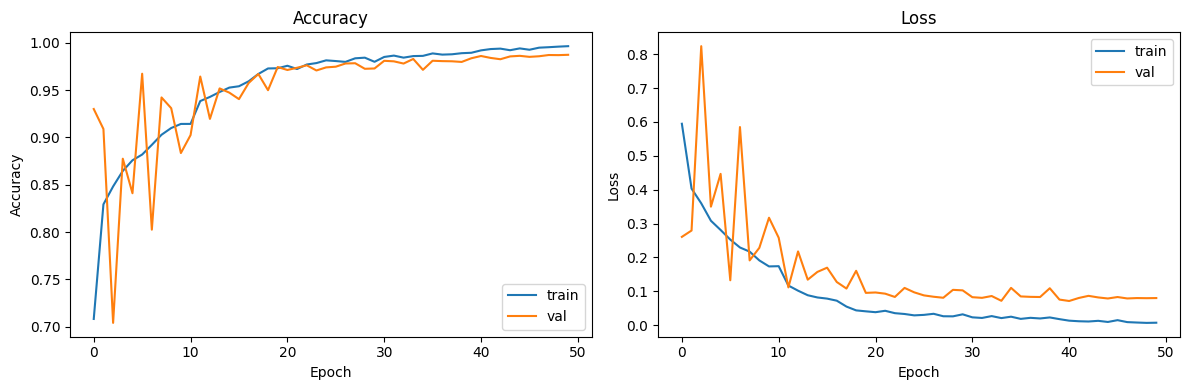

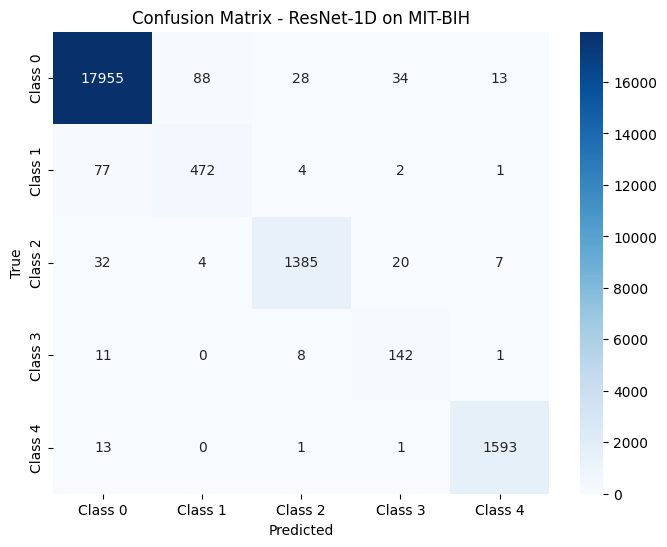

In [26]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.title("Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"Class {c}" for c in le.classes_.astype(int)],
            yticklabels=[f"Class {c}" for c in le.classes_.astype(int)])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - ResNet-1D on MIT-BIH")

plt.show()


Number of misclassified samples: 345


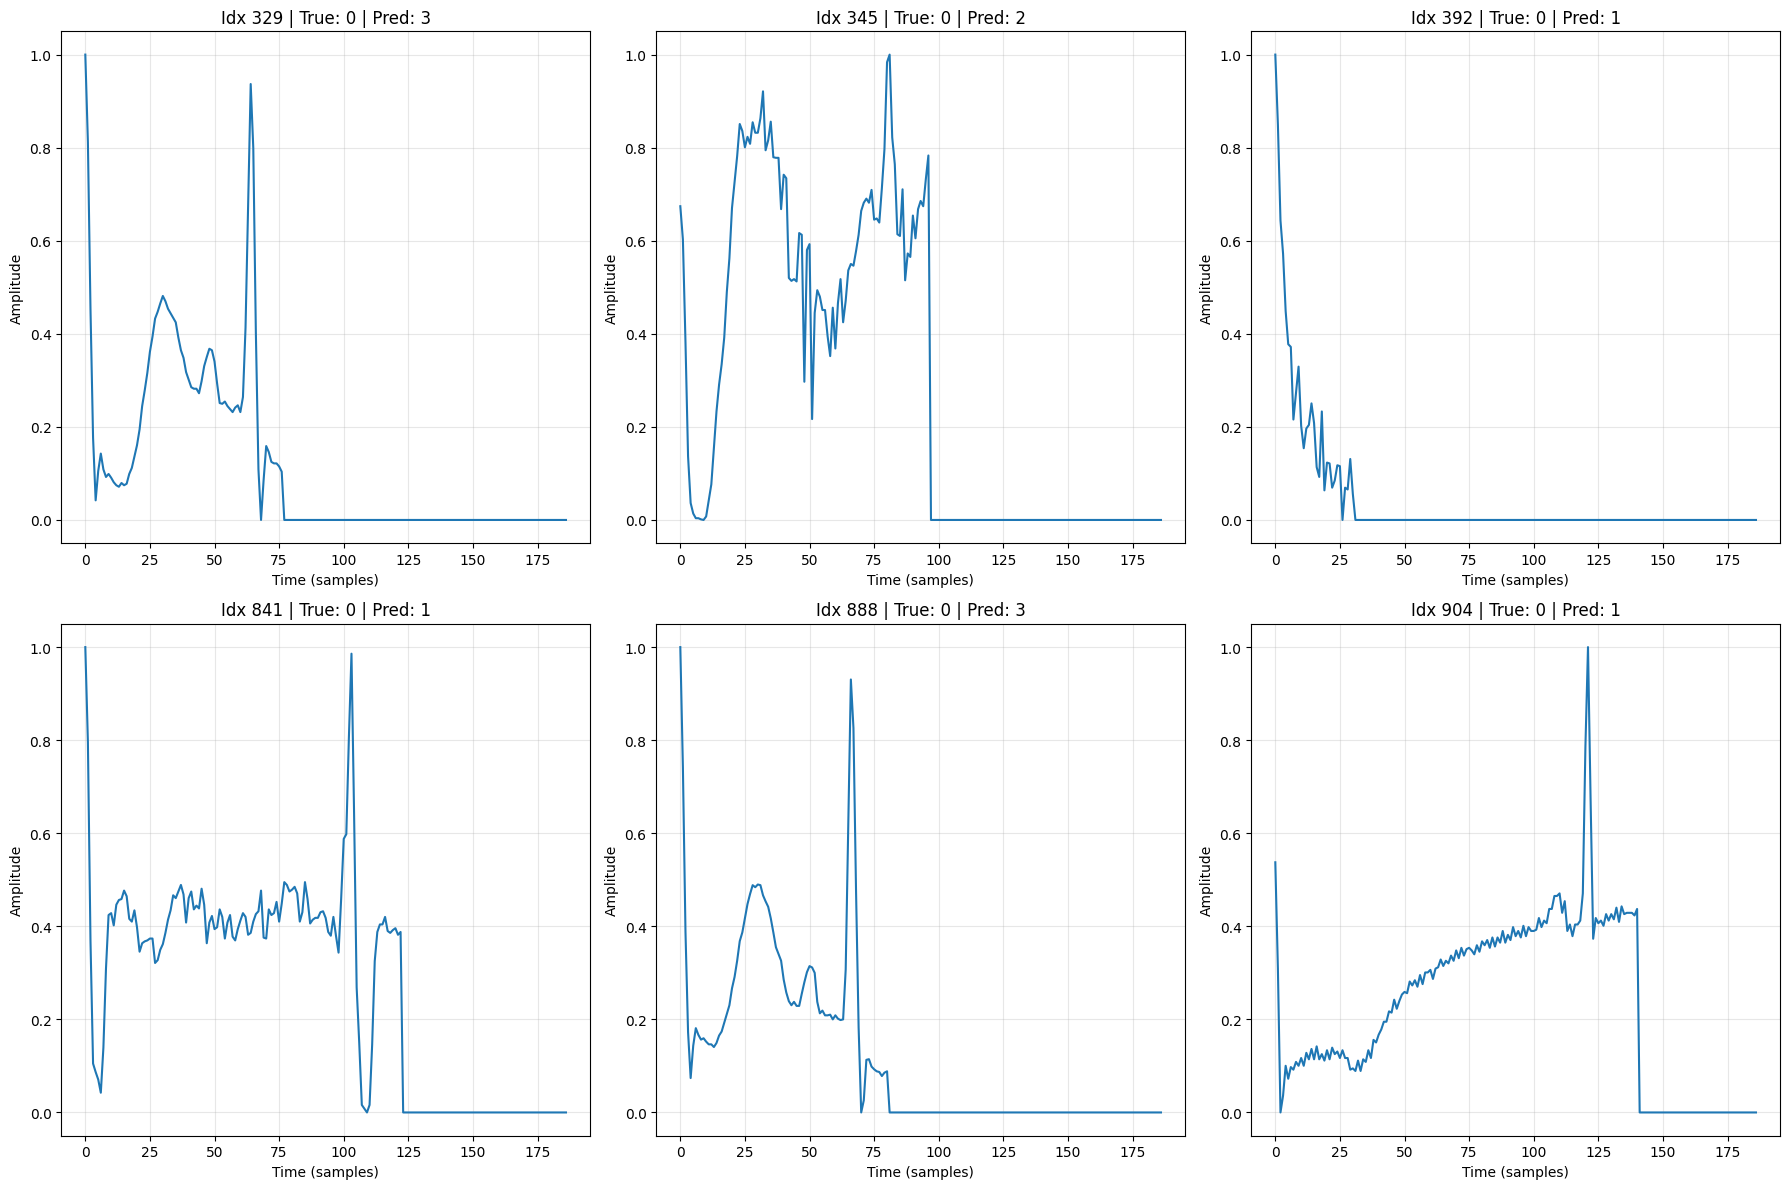

In [16]:
mis_idx = np.where(y_test_enc != y_pred_cls)[0]
print(f"\nNumber of misclassified samples: {len(mis_idx)}")

n_show = min(6, len(mis_idx))
if n_show > 0:
    fig, axes = plt.subplots(n_show//3 + (1 if n_show % 3 else 0), 3, figsize=(18, 4 * (n_show//3 + 1)))
    axes = np.array(axes).reshape(-1) \
    for i in range(n_show):
        idx = mis_idx[i]
        signal = X_test[idx].squeeze()
        true_label = le.classes_[y_test_enc[idx]]
        pred_label = le.classes_[y_pred_cls[idx]]

        axes[i].plot(signal)
        axes[i].set_title(f"Idx {idx} | True: {true_label:.0f} | Pred: {pred_label:.0f}")
        axes[i].set_xlabel('Time (samples)')
        axes[i].set_ylabel('Amplitude')
        axes[i].grid(alpha=0.3)

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No misclassified examples to show (perfect accuracy).")